In [ ]:
import pandas as pd
import re
import spacy

In [ ]:
pip install spacy==2.1.0 

     |████████████████████████████████| 27.7MB 148kB/s 
     |████████████████████████████████| 2.1MB 40.7MB/s 
     |████████████████████████████████| 3.2MB 35.5MB/s 
     |████████████████████████████████| 92kB 9.4MB/s 
ERROR: en-core-web-sm 2.2.5 has requirement spacy>=2.2.2, but you'll have spacy 2.1.0 which is incompatible.
  Found existing installation: plac 1.1.3
    Uninstalling plac-1.1.3:
      Successfully uninstalled plac-1.1.3
  Found existing installation: blis 0.4.1
    Uninstalling blis-0.4.1:
      Successfully uninstalled blis-0.4.1
  Found existing installation: preshed 3.0.2
    Uninstalling preshed-3.0.2:
      Successfully uninstalled preshed-3.0.2
  Found existing installation: thinc 7.4.0
    Uninstalling thinc-7.4.0:
      Successfully uninstalled thinc-7.4.0
  Found existing installation: spacy 2.2.4
    Uninstalling spacy-2.2.4:
      Successfully uninstalled spacy-2.2.4


In [ ]:
pip install https://github.com/explosion/spacy-models/releases/download/en_core_web_sm-2.1.0/en_core_web_sm-2.1.0.tar.gz

     |████████████████████████████████| 11.1MB 772kB/s 
  Created wheel for en-core-web-sm: filename=en_core_web_sm-2.1.0-cp36-none-any.whl size=11074435 sha256=8b2f2c40b46a5e0d342eaf8471e8b51afb1ccf58d272372ee82ca1fdafd0a589
  Stored in directory: /root/.cache/pip/wheels/39/ea/3b/507f7df78be8631a7a3d7090962194cf55bc1158572c0be77f
Successfully built en-core-web-sm
  Found existing installation: en-core-web-sm 2.2.5
    Uninstalling en-core-web-sm-2.2.5:
      Successfully uninstalled en-core-web-sm-2.2.5


In [ ]:
pip install neuralcoref --no-binary neuralcoref

     |████████████████████████████████| 378kB 2.7MB/s 
Skipping wheel build for neuralcoref, due to binaries being disabled for it.
    Running setup.py install for neuralcoref ... done


In [ ]:
import en_core_web_sm

In [ ]:
!pip install wikipedia-api

  Created wheel for wikipedia-api: filename=Wikipedia_API-0.5.4-cp36-none-any.whl size=13462 sha256=c2ec3c9bfeaaaabb08f116d7ddd58e8b73cd956777c6170adefc0b795690585a
  Stored in directory: /root/.cache/pip/wheels/bf/40/42/ba1d497f3712281b659dd65b566fc868035c859239571a725a
Successfully built wikipedia-api


In [ ]:
import wikipediaapi  # pip install wikipedia-api
import pandas as pd
import concurrent.futures
from tqdm import tqdm

In [ ]:
def wiki_scrape(topic_name, verbose=True):
    def wiki_link(link):
        try:
            page = wiki_api.page(link)
            if page.exists():
                d = {'page': link, 'text': page.text, 'link': page.fullurl,
                     'categories': list(page.categories.keys())}
                return d
        except:
            return None

    wiki_api = wikipediaapi.Wikipedia(language='en',
        extract_format=wikipediaapi.ExtractFormat.WIKI)
    page_name = wiki_api.page(topic_name)
    if not page_name.exists():
        print('page {} does not exist'.format(topic_name))
        return
    page_links = list(page_name.links.keys())
    progress = tqdm(desc='Links Scraped', unit='', total=len(page_links)) if verbose else None
    sources = [{'page': topic_name, 'text': page_name.text, 'link': page_name.fullurl,
                'categories': list(page_name.categories.keys())}]
    with concurrent.futures.ThreadPoolExecutor(max_workers=5) as executor:
        future_link = {executor.submit(wiki_link, link): link for link in page_links}
        for future in concurrent.futures.as_completed(future_link):
            data = future.result()
            progress.update(1) if verbose else None
            if data:
                sources.append(data)
    progress.close() if verbose else None
    blacklist = ('Template', 'Help:', 'Category:', 'Portal:', 'Wikipedia:', 'Talk:')
    sources = pd.DataFrame(sources)
    sources = sources[(len(sources['text']) > 20)
                      & ~(sources['page'].str.startswith(blacklist))]
    sources['categories'] = sources.categories.apply(lambda x: [y[9:] for y in x])
    sources['topic'] = topic_name
    print ('Wikipedia pages scraped:', len(sources))
    return sources

In [ ]:
wiki_data1 = wiki_scrape('Flu')

Links Scraped: 100%|██████████| 706/706 [00:32<00:00, 21.99/s]

Wikipedia pages scraped: 677


In [ ]:
wiki_data2 = wiki_scrape('Medicine')

Links Scraped: 100%|██████████| 710/710 [00:35<00:00, 19.97/s]

Wikipedia pages scraped: 688


In [ ]:
wiki_data3 = wiki_scrape('Plague')

Links Scraped: 100%|██████████| 55/55 [00:03<00:00, 17.63/s]

Wikipedia pages scraped: 54


In [ ]:
wiki_data4= wiki_scrape('Symptoms')

Links Scraped: 100%|██████████| 531/531 [00:24<00:00, 21.56/s]

Wikipedia pages scraped: 504


In [ ]:
print(wiki_data1.loc[0,'text'])

In [ ]:
wiki_data1.to_csv('Flu.csv')

In [ ]:
wiki_data2.to_csv('Medicine.csv')

In [ ]:
wiki_data3.to_csv('Plague.csv')

In [ ]:
wiki_data4.to_csv('Symptoms.csv')

In [ ]:
import neuralcoref

nlp = spacy.load('en_core_web_sm')

neuralcoref.add_to_pipe(nlp)
doc = nlp(u'Deepika has a dog. She loves him. The movie star has always been fond of animals')

100%|██████████| 40155833/40155833 [00:00<00:00, 58898820.38B/s]


In [ ]:
def filter_spans(spans):
    # Filter a sequence of spans so they don't contain overlaps
    # For spaCy 2.1.4+: this function is available as spacy.util.filter_spans()
    get_sort_key = lambda span: (span.end - span.start, -span.start)
    sorted_spans = sorted(spans, key=get_sort_key, reverse=True)
    result = []
    seen_tokens = set()
    for span in sorted_spans:
        # Check for end - 1 here because boundaries are inclusive
        if span.start not in seen_tokens and span.end - 1 not in seen_tokens:
            result.append(span)
        seen_tokens.update(range(span.start, span.end))
    result = sorted(result, key=lambda span: span.start)
    return result


In [ ]:
nlp = spacy.load('en_core_web_sm')
neuralcoref.add_to_pipe(nlp)


def entity_pairs(text, coref=True):
    text = re.sub(r'\n+', '.', text)  # replace multiple newlines with period
    text = re.sub(r'\[\d+\]', ' ', text)  # remove reference numbers
    text = text.lower()
    text = nlp(text)
    if coref:
        text = nlp(text._.coref_resolved)  # resolve coreference clusters
    sentences = [sent.string.strip() for sent in text.sents]  # split text into sentences
    ent_pairs = list()
    for sent in sentences:
        sent = nlp(sent)
        spans = list(sent.ents) + list(sent.noun_chunks)  # collect nodes
        spans = filter_spans(spans)
        with sent.retokenize() as retokenizer:
            [retokenizer.merge(span) for span in spans]
        dep = [token.dep_ for token in sent]
        if (dep.count('obj')+dep.count('dobj'))==1 \
                and (dep.count('subj')+dep.count('nsubj'))==1:
            for token in sent:
                if token.dep_ in ('obj', 'dobj'):  # identify object nodes
                    subject = [w for w in token.head.lefts if w.dep_
                               in ('subj', 'nsubj')]  # identify subject nodes
                    if subject:
                        subject = subject[0]
                        # identify relationship by root dependency
                        relation = [w for w in token.ancestors if w.dep_ == 'ROOT']  
                        if relation:
                            relation = relation[0]
                            # add adposition or particle to relationship
                            if relation.nbor(1).pos_ in ('ADP', 'PART'):  
                                relation = ' '.join((str(relation),
                                        str(relation.nbor(1))))
                        else:
                            relation = 'unknown'
                        subject, subject_type = refine_ent(subject, sent)
                        token, object_type = refine_ent(token, sent)
                        ent_pairs.append([str(subject), str(relation), str(token),
                                str(subject_type), str(object_type)])
    filtered_ent_pairs = [sublist for sublist in ent_pairs
                          if not any(str(x) == '' for x in sublist)]
    pairs = pd.DataFrame(filtered_ent_pairs, columns=['subject',
                         'relation', 'object', 'subject_type',
                         'object_type'])
    print('Entity pairs extracted:', str(len(filtered_ent_pairs)))
    return pairs


def refine_ent(ent, sent):
    unwanted_tokens = (
        'PRON',  # pronouns
        'PART',  # particle
        'DET',  # determiner
        'SCONJ',  # subordinating conjunction
        'PUNCT',  # punctuation
        'SYM',  # symbol
        'X',  # other
        )
    ent_type = ent.ent_type_  # get entity type
    if ent_type == '':
        ent_type = 'NOUN_CHUNK'
        ent = ' '.join(str(t.text) for t in
                nlp(str(ent)) if t.pos_
                not in unwanted_tokens and t.is_stop == False)
    elif ent_type in ('NOMINAL', 'CARDINAL', 'ORDINAL') and str(ent).find(' ') == -1:
        t = ''
        for i in range(len(sent) - ent.i):
            if ent.nbor(i).pos_ not in ('VERB', 'PUNCT'):
                t += ' ' + str(ent.nbor(i))
            else:
                ent = t.strip()
                break
    return ent, ent_type


In [ ]:
pairs1d= pd.DataFrame()
for i in range(1295):
  pairs1 = entity_pairs(wiki_data1.loc[i,'text'])
  pairs1d = pairs1d.append(pairs1, ignore_index=True)

Entity pairs extracted: 36
Entity pairs extracted: 13
Entity pairs extracted: 13
Entity pairs extracted: 7
Entity pairs extracted: 7
Entity pairs extracted: 33
Entity pairs extracted: 7
Entity pairs extracted: 33
Entity pairs extracted: 7
Entity pairs extracted: 6
Entity pairs extracted: 3
Entity pairs extracted: 12
Entity pairs extracted: 3
Entity pairs extracted: 1
Entity pairs extracted: 32
Entity pairs extracted: 32
Entity pairs extracted: 7
Entity pairs extracted: 7
Entity pairs extracted: 9
Entity pairs extracted: 8
Entity pairs extracted: 10
Entity pairs extracted: 16
Entity pairs extracted: 62
Entity pairs extracted: 23
Entity pairs extracted: 12
Entity pairs extracted: 2
Entity pairs extracted: 20
Entity pairs extracted: 3
Entity pairs extracted: 6
Entity pairs extracted: 9
Entity pairs extracted: 9
Entity pairs extracted: 16
Entity pairs extracted: 2
Entity pairs extracted: 18
Entity pairs extracted: 12
Entity pairs extracted: 12
Entity pairs extracted: 0
Entity pairs extract

IndexError: ignored

In [ ]:
print(pairs1d)

NameError: ignored

In [ ]:

for i in range(700):
  pairs2 = entity_pairs(wiki_data2.loc[i,'text'])
  pairs1d = pairs1d.append(pairs2, ignore_index=True)

Entity pairs extracted: 51
Entity pairs extracted: 18
Entity pairs extracted: 11
Entity pairs extracted: 12
Entity pairs extracted: 23
Entity pairs extracted: 0
Entity pairs extracted: 17
Entity pairs extracted: 0
Entity pairs extracted: 5
Entity pairs extracted: 35
Entity pairs extracted: 4
Entity pairs extracted: 2
Entity pairs extracted: 2
Entity pairs extracted: 3
Entity pairs extracted: 18
Entity pairs extracted: 6
Entity pairs extracted: 17
Entity pairs extracted: 9
Entity pairs extracted: 43
Entity pairs extracted: 44
Entity pairs extracted: 6
Entity pairs extracted: 4
Entity pairs extracted: 5
Entity pairs extracted: 28
Entity pairs extracted: 4
Entity pairs extracted: 18
Entity pairs extracted: 5
Entity pairs extracted: 11
Entity pairs extracted: 3
Entity pairs extracted: 20
Entity pairs extracted: 47
Entity pairs extracted: 8
Entity pairs extracted: 14
Entity pairs extracted: 18
Entity pairs extracted: 18
Entity pairs extracted: 2
Entity pairs extracted: 24
Entity pairs extra

IndexError: ignored

In [ ]:
print(pairs1d)

                                           subject  ... object_type
0                                  common symptoms  ...  NOUN_CHUNK
1                                    Complications  ...  NOUN_CHUNK
2     Three of the four types of influenza viruses  ...  NOUN_CHUNK
3                    The World Health Organization  ...  NOUN_CHUNK
4                                        Influenza  ...  NOUN_CHUNK
...                                            ...  ...         ...
1133                                           ABA  ...  NOUN_CHUNK
1134                             Arterial diseases  ...  NOUN_CHUNK
1135                            Lymphatic diseases  ...  NOUN_CHUNK
1136                            Lymphatic diseases  ...  NOUN_CHUNK
1137                                    twelve NIH  ...        DATE

[1138 rows x 5 columns]


In [ ]:
for i in range(55):
  pairs3 = entity_pairs(wiki_data3.loc[i,'text'])
  pairs1d = pairs1d.append(pairs3, ignore_index=True)

Entity pairs extracted: 1
Entity pairs extracted: 33
Entity pairs extracted: 3
Entity pairs extracted: 4
Entity pairs extracted: 2
Entity pairs extracted: 23
Entity pairs extracted: 7
Entity pairs extracted: 3
Entity pairs extracted: 11
Entity pairs extracted: 10
Entity pairs extracted: 0
Entity pairs extracted: 1
Entity pairs extracted: 1
Entity pairs extracted: 4
Entity pairs extracted: 54
Entity pairs extracted: 8
Entity pairs extracted: 0
Entity pairs extracted: 8
Entity pairs extracted: 7
Entity pairs extracted: 0
Entity pairs extracted: 0
Entity pairs extracted: 2
Entity pairs extracted: 0
Entity pairs extracted: 1
Entity pairs extracted: 12
Entity pairs extracted: 3
Entity pairs extracted: 2
Entity pairs extracted: 2
Entity pairs extracted: 8
Entity pairs extracted: 14
Entity pairs extracted: 3
Entity pairs extracted: 5
Entity pairs extracted: 0
Entity pairs extracted: 4
Entity pairs extracted: 1
Entity pairs extracted: 24
Entity pairs extracted: 5
Entity pairs extracted: 42
Ent

KeyError: ignored

In [ ]:
print(pairs1d)

                                           subject  ... object_type
0                                  common symptoms  ...  NOUN_CHUNK
1                                    Complications  ...  NOUN_CHUNK
2     Three of the four types of influenza viruses  ...  NOUN_CHUNK
3                    The World Health Organization  ...  NOUN_CHUNK
4                                        Influenza  ...  NOUN_CHUNK
...                                            ...  ...         ...
1531                               Public reaction  ...  NOUN_CHUNK
1532                                       network  ...  NOUN_CHUNK
1533                                        design  ...  NOUN_CHUNK
1534           French researcher Paul-Louis Simond  ...  NOUN_CHUNK
1535                                        number  ...    CARDINAL

[1536 rows x 5 columns]


In [ ]:
for i in range(575):
  pairs4 = entity_pairs(wiki_data4.loc[i,'text'])
  pairs1d = pairs1d.append(pairs4, ignore_index=True)

Entity pairs extracted: 2
Entity pairs extracted: 0
Entity pairs extracted: 8
Entity pairs extracted: 6
Entity pairs extracted: 6
Entity pairs extracted: 2
Entity pairs extracted: 1
Entity pairs extracted: 9
Entity pairs extracted: 0
Entity pairs extracted: 1
Entity pairs extracted: 1
Entity pairs extracted: 2
Entity pairs extracted: 3
Entity pairs extracted: 24
Entity pairs extracted: 7
Entity pairs extracted: 0
Entity pairs extracted: 17
Entity pairs extracted: 1
Entity pairs extracted: 35
Entity pairs extracted: 38
Entity pairs extracted: 18
Entity pairs extracted: 11
Entity pairs extracted: 5
Entity pairs extracted: 4
Entity pairs extracted: 0
Entity pairs extracted: 12
Entity pairs extracted: 0
Entity pairs extracted: 8
Entity pairs extracted: 28
Entity pairs extracted: 13
Entity pairs extracted: 1
Entity pairs extracted: 2
Entity pairs extracted: 3
Entity pairs extracted: 4
Entity pairs extracted: 11
Entity pairs extracted: 0
Entity pairs extracted: 4
Entity pairs extracted: 2
En

IndexError: ignored

In [ ]:
print(pairs1d)

                                           subject  ... object_type
0                                  common symptoms  ...  NOUN_CHUNK
1                                    Complications  ...  NOUN_CHUNK
2     Three of the four types of influenza viruses  ...  NOUN_CHUNK
3                    The World Health Organization  ...  NOUN_CHUNK
4                                        Influenza  ...  NOUN_CHUNK
...                                            ...  ...         ...
5053                         Clinical laboratories  ...         ORG
5054                                          body  ...  NOUN_CHUNK
5055                                renal patients  ...  NOUN_CHUNK
5056                                       patient  ...  NOUN_CHUNK
5057                                      patients  ...  NOUN_CHUNK

[5058 rows x 5 columns]


In [ ]:
pairs1d.to_csv('Combined.csv')

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt


def draw_kg(pairs):
    k_graph = nx.from_pandas_edgelist(pairs, 'subject', 'object',
            create_using=nx.MultiDiGraph())
    node_deg = nx.degree(k_graph)
    layout = nx.spring_layout(k_graph, k=0.15, iterations=20)
    plt.figure(num=None, figsize=(10, 90), dpi=80)
    nx.draw_networkx(
        k_graph,
        node_size=[int(deg[1]) * 500 for deg in node_deg],
        arrowsize=20,
        linewidths=1.5,
        pos=layout,
        edge_color='red',
        edgecolors='black',
        node_color='white',
        )
    labels = dict(zip(list(zip(pairs.subject, pairs.object)),
                  pairs['relation'].tolist()))
    nx.draw_networkx_edge_labels(k_graph, pos=layout, edge_labels=labels,
                                 font_color='red')
    plt.axis('off')
    plt.show()

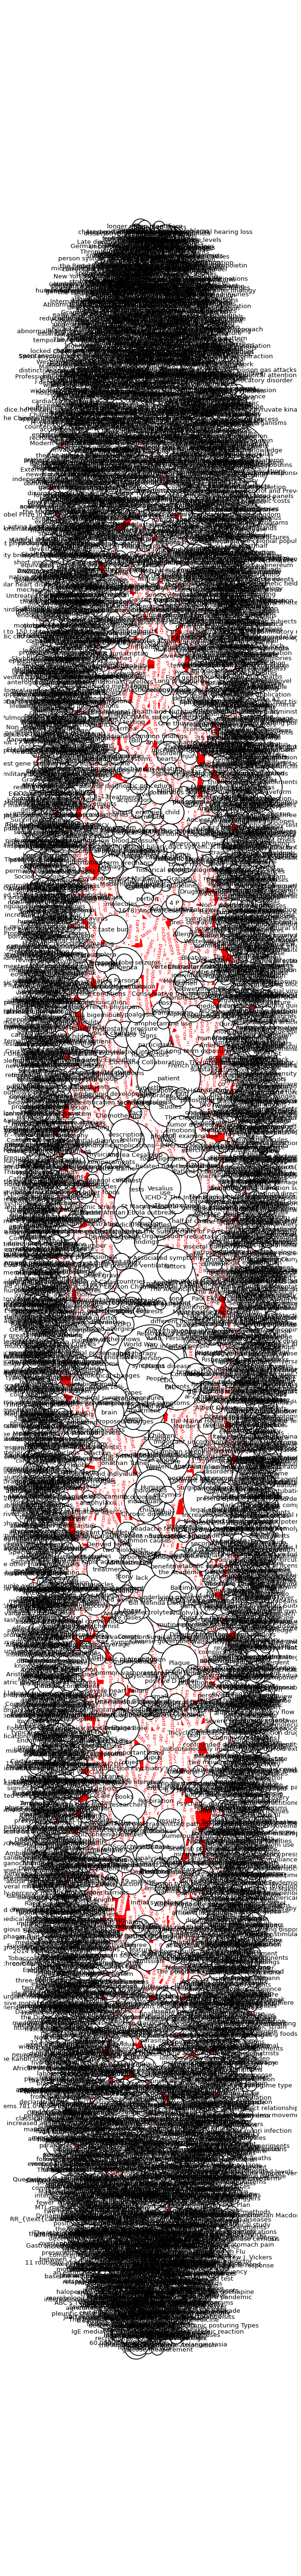

In [ ]:
draw_kg(pairs1d)

In [ ]:
def filter_graph(pairs, node):
    k_graph = nx.from_pandas_edgelist(pairs, 'subject', 'object',
            create_using=nx.MultiDiGraph())
    edges = nx.dfs_successors(k_graph, node)
    nodes = []
    for k, v in edges.items():
        nodes.extend([k])
        nodes.extend(v)
    subgraph = k_graph.subgraph(nodes)
    layout = (nx.random_layout(k_graph))
    nx.draw_networkx(
        subgraph,
        node_size=1000,
        arrowsize=20,
        linewidths=1.5,
        pos=layout,
        edge_color='red',
        edgecolors='black',
        node_color='white'
        )
    labels = dict(zip((list(zip(pairs.subject, pairs.object))),
                    pairs['relation'].tolist()))
    edges= tuple(subgraph.out_edges(data=False))
    sublabels ={k: labels[k] for k in edges}
    nx.draw_networkx_edge_labels(subgraph, pos=layout, edge_labels=sublabels,
                                font_color='red')
    plt.axis('off')
    plt.show()

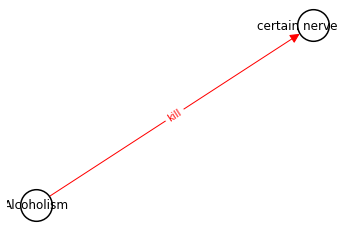

In [ ]:
filter_graph(pairs1d, 'Alcoholism')


In [ ]:
import spacy


nlp = spacy.load("en_core_web_sm")

text=wiki_data.loc[0,'text']

tagged_text = nlp(text)

extracted_entities = [(i.text, i.label_) for i in tagged_text.ents]

print(extracted_entities)

[('2019', 'DATE'), ('2', 'CARDINAL'), ('first', 'ORDINAL'), ('December 2019', 'DATE'), ('Wuhan', 'GPE'), ('Hubei', 'GPE'), ('China', 'GPE'), ('first', 'ORDINAL'), ('17', 'CARDINAL'), ('Hubei', 'GPE'), ('2 July 2020', 'DATE'), ('more than 10.6 million', 'CARDINAL'), ('188', 'CARDINAL'), ('more than 516,000', 'CARDINAL'), ('More than 5.48 million', 'CARDINAL'), ('ARDS', 'ORG'), ('around five days', 'DATE'), ('two to fourteen days', 'DATE'), ('June 2020', 'DATE'), ('tens of minutes', 'TIME'), ('the first three days', 'DATE'), ('CT', 'ORG'), ('N95', 'PRODUCT'), ('first', 'ORDINAL'), ('COVID-19', 'PRODUCT'), ('The World Health Organization', 'ORG'), ('COVID‑19', 'PRODUCT'), ('30 January 2020', 'DATE'), ('11 March 2020', 'DATE'), ('six', 'CARDINAL'), ('Signs', 'PERSON'), ('Fever', 'PERSON'), ('COVID-19', 'NORP'), ('one', 'CARDINAL'), ('only 44%', 'PERCENT'), ('89%', 'PERCENT'), ('China', 'GPE'), ('30%', 'PERCENT'), ('South Korea', 'GPE'), ('first', 'ORDINAL'), ('COVID‑19', 'GPE'), ('five or 

In [ ]:
!pip install pyprind

In [ ]:
import pandas as pd

from tensorflow.python.keras import Sequential
from tensorflow.python.keras import layers
from tensorflow.python.keras import regularizers
from tensorflow.python.keras.preprocessing.text import Tokenizer

import numpy as np
from string import punctuation
import pyprind
from collections import Counter
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import re
import nltk
import pandas as pd
from nltk.stem import PorterStemmer
nltk.download('punkt')
from nltk.tokenize import sent_tokenize, word_tokenize
nltk.download('stopwords')
nltk.download('words')
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer 
from sklearn.feature_extraction.text import *
from sklearn.ensemble import *
from sklearn.model_selection import *
from sklearn import neighbors

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Unzipping corpora/words.zip.


In [ ]:
# settings that you use for count vectorizer will go here
tfidf_vectorizer=TfidfVectorizer(use_idf=True)
 
# just send in all your docs here
tfidf_vectorizer_vectors=tfidf_vectorizer.fit_transform(str(e) for e in wiki_data['text'])


# get the first vector out (for the first document)
first_vector_tfidfvectorizer=tfidf_vectorizer_vectors[0]
# place tf-idf values in a pandas data frame
df = pd.DataFrame(first_vector_tfidfvectorizer.T.todense(), index=tfidf_vectorizer.get_feature_names(), columns=["tfidf"])
df.sort_values(by=["tfidf"],ascending=False)

tfidf
the            0.493379
of             0.363822
and            0.283234
to             0.229985
in             0.201555
...                 ...
extermination  0.000000
exterminating  0.000000
exterminate    0.000000
exterior       0.000000
ﬁnancial       0.000000

[78811 rows x 1 columns]

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
v = TfidfVectorizer()
x = v.fit_transform(str(e) for e in  wiki_data['text'])
z=x.toarray()

In [ ]:
z.shape

(1300, 78811)

In [ ]:
 wiki_data['tf-idf_verctor']=pd.Series(z.tolist())

In [ ]:
wiki_data

page  ...                                     tf-idf_verctor
0                                              COVID  ...  [0.0, 0.0021335606022233407, 0.0, 0.0, 0.0, 0....
1                                2020 Global Famines  ...  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
2     2020 Indonesia large-scale social restrictions  ...  [0.04024598573343466, 0.0, 0.0, 0.0, 0.0, 0.0,...
3             2020 Russia–Saudi Arabia oil price war  ...  [0.0, 0.030480998456450126, 0.0, 0.0, 0.0, 0.0...
4          2020 United States anti-lockdown protests  ...  [0.0, 0.008160792528189208, 0.0, 0.0, 0.0, 0.0...
...                                              ...  ...                                                ...
1295                                   Zhang Wenhong  ...  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
1296                                   Zhong Nanshan  ...  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
1297                                Łukasz Szumowski  ...  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
1298                                      Zika virus  ...  [0.0, 0.003287356575948927, 0.0, 0.0, 0.0, 0.0...
1299                                        Zoonosis  ...  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...

[1300 rows x 6 columns]